In [ ]:
#| default_exp RoPE

In [ ]:
try:
    import google.colab
    !pip install -q git+https://github.com/tripathysagar/NanoTransformer.git
except Exception as e:
    pass

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from NanoTransformer.data import *
import NanoTransformer.GPTText2Text as gpt_module
from NanoTransformer.ImageEncoder import *
from NanoTransformer.MultiModal import *

gptConfig = gpt_module.gptConfig


# training vison encoder
vision_encoder_train(classifier, 5)

Epoch 	Train Loss 	Valid Loss 	accurecy
1   	0.4402   	0.3328		0.8752
2   	0.2984   	0.3232		0.8819
3   	0.2481   	0.2814		0.8949
4   	0.2169   	0.2831		0.8988
5   	0.1857   	0.2617		0.9086


The basic traansfomer gpt2 char-wise on shakespre text and extend it to use multi modal format to process for Fashion MNIST captioning. Used pytorch.
```py
#|export
import torch
from torch import nn
class Embedding(nn.Module):
    def __init__(self, config:GPTConfig):
        super().__init__()
        self.register_buffer('pos_ids', torch.arange(config.seq_len))  # for adding the postional encoding from 0 to seq_len - 1

        self.embed = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.pos_embed =  nn.Embedding(config.seq_len, config.embedding_dim)

    def forward(self, x, start_idx=0):           #bs * seq_len
        return self.embed(x) + self.pos_embed(self.pos_ids[start_idx:start_idx+x.size(1)])     #bs * seq_len * embedding_dim
```

The `positional encoding` used in the embedding layer have a fixed length i.e. `128`. It can be thought of absolute postional embedding rather than using enter token one(relative). It is brittle easy to break. The motivation for RoPE(Rotary Position Embeddings)

**1. Relative vs Absolute Position**
Your current learned embeddings tell the model "this is position 5" or "this is position 127" (absolute). But what's often more useful is knowing "these two tokens are 3 positions apart" (relative). RoPE naturally encodes relative positions through its rotation mechanism.

**2. Length Generalization**
You mentioned this—with learned embeddings, if you train on sequences up to length 512, you literally don't have embeddings for position 513+. With RoPE, the rotation pattern continues smoothly, so the model can handle longer sequences at inference time (though not infinitely longer—there are still limits).

**3. How the rotation achieves this**
Here's the clever part: when you rotate query vector Q by angle θ_i and key vector K by angle θ_j, their dot product (in attention) depends on (θ_i - θ_j), which is the *relative* distance between positions i and j.

Yes explaint the matn behind

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's look at the math. I'll break it down step by step.

**The Core Idea: 2D Rotation**

Imagine we have a 2D vector [x, y]. We can rotate it by angle θ using this rotation matrix:

```
[cos(θ)  -sin(θ)]   [x]
[sin(θ)   cos(θ)]   [y]
```

For position `m`, RoPE rotates pairs of dimensions in your query/key vectors. The rotation angle depends on:
- The position `m` (where the token is in the sequence)
- Which dimension pair we're rotating (different pairs use different base frequencies)

**The angle formula:**
For dimension pair `i`, at position `m`:
```
θ_m,i = m × θ_i
where θ_i = 1 / (10000^(2i/d))
```

Here `d` is your embedding dimension, and `i` goes from 0, 1, 2... for each pair.

**Key insight:** When computing attention between position m and position n, the dot product ends up depending on `(m-n) × θ_i`, which is the *relative* distance!

Does this make sense so far? Should I clarify any part before we move to how this looks in code?

Can you clarify the math behind it ? how it is dependent

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great question! Let me show you why the dot product depends on relative position (m - n).

**Setup:**
- Query vector Q at position m gets rotated by angle: θ_m = m × θ_i
- Key vector K at position n gets rotated by angle: θ_n = n × θ_i

**For a 2D pair [q₁, q₂] and [k₁, k₂]:**

After rotation:
```
Q_rotated = [q₁·cos(m·θ) - q₂·sin(m·θ), q₁·sin(m·θ) + q₂·cos(m·θ)]
K_rotated = [k₁·cos(n·θ) - k₂·sin(n·θ), k₁·sin(n·θ) + k₂·cos(n·θ)]
```

**The dot product:**
When you compute Q_rotated · K_rotated and apply trigonometric identities (cos(A)cos(B) + sin(A)sin(B) = cos(A-B)), you get terms that depend on:

```
cos((m-n)·θ) and sin((m-n)·θ)
```

See it? The angles combine to give **(m - n)**, which is the relative distance between positions!

This is the elegant part: the attention score naturally encodes "how far apart are these tokens?" rather than "what absolute positions are they at?"

Does this click? Would you like me to work through the trigonometric identity step, or are you ready to think about implementation?

The angle thing is fixed right?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! Let me clarify what's fixed and what varies:

**Fixed:**
- θᵢ (the base angle for dimension pair i) - this is fixed based on the formula θᵢ = 1 / (10000^(2i/d))
- Different dimension pairs have different fixed θᵢ values

**Varies:**
- The actual rotation angle: **m × θᵢ** - this changes based on which position m you're at

So for example:
- Dimension pair 0 has θ₀ = 1 (fixed)
- At position 0: rotation angle = 0 × θ₀ = 0
- At position 1: rotation angle = 1 × θ₀ = θ₀
- At position 5: rotation angle = 5 × θ₀ = 5θ₀

The pattern is fixed, but each position gets progressively more rotation.

Does that distinction make sense? Is this what you were asking about?

explain the the formula once again

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Sure! Let's break down the formula:

**θᵢ = 1 / (10000^(2i/d))**

Where:
- **d** = your embedding dimension (e.g., if your embedding is 128-dimensional, d = 128)
- **i** = which dimension pair you're working on (i = 0, 1, 2, 3, ...)
- **10000** = a constant (this gives a good range of frequencies)

**What it does:**
- For i = 0 (first pair): θ₀ = 1 / (10000^0) = 1 (fastest rotation)
- For i = 1 (second pair): θ₁ = 1 / (10000^(2/d)) (slower rotation)
- For i = 2 (third pair): θ₂ = 1 / (10000^(4/d)) (even slower)
- ...and so on

Each dimension pair rotates at a different speed. Lower dimension pairs rotate faster, higher ones rotate slower. This creates different "wavelengths" of position information, kind of like how Fourier analysis uses different frequencies.

Does this clarify it? What part still seems confusing?

The calculation of RoPE is done on Q and K matrix right. So it is taken on pair wise basis i.e. 64 pairs each for 128as context lenght.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

I think there's a small mix-up here. Let me clarify:

**RoPE operates on two different dimensions:**

1. **Embedding dimension (d)**: If your embedding is 128-dimensional, you split it into d/2 = 64 pairs. Each pair gets rotated.

2. **Sequence position (m)**: This is the position in your sequence (context length). If your context length is 512, you have positions m = 0, 1, 2, ..., 511.

**How they combine:**
- Each of the 64 dimension pairs has its own base angle θᵢ
- Each position m in your sequence uses rotation angle m × θᵢ

So for a token at position m=5 with embedding dim 128:
- Dimension pair 0 gets rotated by 5 × θ₀
- Dimension pair 1 gets rotated by 5 × θ₁
- ... all 64 pairs get rotated

Does this clarify the difference between embedding dimension and sequence position?

it will be called on each Q and K ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes, exactly! RoPE is applied to both Q and K matrices (but **not** to V).

Typically in your attention mechanism, after you compute Q, K, V from your input, you would:

1. Apply RoPE to Q
2. Apply RoPE to K  
3. Leave V unchanged
4. Then compute attention as usual: softmax(QK^T / sqrt(d)) × V

Do you have your attention mechanism code handy? Where in your current code do you compute Q, K, and V?

lets implemet rope

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Let's implement RoPE step by step.

First, let's create a function to compute the base angles θᵢ for each dimension pair.

Can you write a function that:
- Takes `d` (embedding dimension) as input
- Returns a tensor of shape (d/2,) containing θᵢ = 1 / (10000^(2i/d)) for i = 0, 1, 2, ..., d/2-1

Give it a try! What would you write?

In [ ]:
import torch
t = torch.arange(20)
t

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])

In [ ]:
d = 20
def fun(i):
    return 1/10000 ** (2*i/d)

[fun(i) for i in t]

[tensor(1.),
 tensor(0.3981),
 tensor(0.1585),
 tensor(0.0631),
 tensor(0.0251),
 tensor(0.0100),
 tensor(0.0040),
 tensor(0.0016),
 tensor(0.0006),
 tensor(0.0003),
 tensor(1.0000e-04),
 tensor(3.9811e-05),
 tensor(1.5849e-05),
 tensor(6.3096e-06),
 tensor(2.5119e-06),
 tensor(1.0000e-06),
 tensor(3.9811e-07),
 tensor(1.5849e-07),
 tensor(6.3096e-08),
 tensor(2.5119e-08)]

In [ ]:
theta = 1.0 / (10000 ** (2 * t / d))
theta

tensor([1.0000e+00, 3.9811e-01, 1.5849e-01, 6.3096e-02, 2.5119e-02, 1.0000e-02,
        3.9811e-03, 1.5849e-03, 6.3096e-04, 2.5119e-04, 1.0000e-04, 3.9811e-05,
        1.5849e-05, 6.3096e-06, 2.5119e-06, 1.0000e-06, 3.9811e-07, 1.5849e-07,
        6.3096e-08, 2.5119e-08])

In [ ]:
t[:,None].shape

torch.Size([20, 1])

In [ ]:
angles = t[:,None] * theta
angles[:3]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 3.9811e-01, 1.5849e-01, 6.3096e-02, 2.5119e-02, 1.0000e-02,
         3.9811e-03, 1.5849e-03, 6.3096e-04, 2.5119e-04, 1.0000e-04, 3.9811e-05,
         1.5849e-05, 6.3096e-06, 2.5119e-06, 1.0000e-06, 3.9811e-07, 1.5849e-07,
         6.3096e-08, 2.5119e-08],
        [2.0000e+00, 7.9621e-01, 3.1698e-01, 1.2619e-01, 5.0238e-02, 2.0000e-02,
         7.9621e-03, 3.1698e-03, 1.2619e-03, 5.0238e-04, 2.0000e-04, 7.9621e-05,
         3.1698e-05, 1.2619e-05, 5.0238e-06, 2.0000e-06, 7.9621e-07, 3.1698e-07,
         1.2619e-07, 5.0238e-08]])

In [ ]:
cos_angles = torch.cos(angles)
sin_angles = torch.sin(angles)

cos_angles.shape

torch.Size([20, 20])

In [ ]:
batch_size, seq_len, d_model = 1, 12, 10
q = torch.randn((batch_size, seq_len, d_model))
q.shape

torch.Size([1, 12, 10])

 We want to go from shape (1, 12, 10) to (1, 12, 5, 2), where the last dimension is the pair [q₁, q₂]

In [ ]:
q_pairs = q.view(batch_size, seq_len, d_model // 2, 2)
q1, q2 = q_pairs[...,0], q_pairs[...,1]
q1.shape

torch.Size([1, 12, 5])

In [ ]:
rotated_q1 = q1 * cos_angles[:seq_len, :5]  - q2 *sin_angles[:seq_len, :5]
rotated_q2 = q1 * sin_angles[:seq_len, :5]  + q2 *cos_angles[:seq_len, :5]
rotated_q1.shape

torch.Size([1, 12, 5])

In [ ]:
final_q = torch.stack([rotated_q1, rotated_q2], dim=-1)
final_q.shape

torch.Size([1, 12, 5, 2])

In [ ]:
q_ = final_q.view(batch_size, seq_len, -1)
q_.shape

torch.Size([1, 12, 10])

## RoPE function

In [ ]:
def apply_rope(x):
    bs, seq_len, emb_dim = x.shape

    # Dimension pair indices as we are finding angles between emb_dim // 2 pairs
    no = torch.arange(emb_dim // 2)
    theta = 1.0 / (10000 ** (2 * no / emb_dim ))    # angle

    # Position indices
    positions = torch.arange(seq_len)
    angles = positions[:, None] * theta             # (seq_len, emb_dim//2)
    angles = angles.to(x.device)

    cos_angles, sin_angles = torch.cos(angles), torch.sin(angles)

    x = x.view(bs, seq_len, emb_dim // 2, 2)
    x1, x2 = x[...,0], x[...,1]

    assert x.shape[-1] == 2

    rotated_x1 = x1 * cos_angles - x2 *sin_angles
    rotated_x2 = x1 * sin_angles + x2 *cos_angles

    assert rotated_x1.shape == rotated_x2.shape

    x = torch.stack([rotated_x1, rotated_x2], dim=-1)

    return x.view(bs, seq_len, -1)

In [ ]:
torch.allclose(apply_rope(q), q_ )

False

In [ ]:
gptConfig.embedding_dim, gptConfig.bs, gptConfig.seq_len

(128, 256, 128)

In [ ]:
import torch.nn as nn

class RoPE(nn.Module):
    def __init__(self, head_dim, seq_len):
        super().__init__()
        self.head_dim = head_dim
        self.seq_len = seq_len

        no = torch.arange(head_dim // 2)
        theta = 1.0 / (10000 ** (2 * no / head_dim ))    # angle

        # Position indices
        positions = torch.arange(seq_len)
        angles = positions[:, None] * theta             # (seq_len, emb_dim//2)

        self.register_buffer('cos_angles', torch.cos(angles))
        self.register_buffer('sin_angles', torch.sin(angles))

    def forward(self, x):
        bs, seq_len, head_dim = x.shape # emb_dim is a name bug but it head_dim is passed

        x = x.view(bs, seq_len, head_dim // 2, 2)
        x1, x2 = x[..., 0], x[..., 1]

        rotated_x1 = x1 * self.cos_angles[:seq_len] - x2 * self.sin_angles[:seq_len]
        rotated_x2 = x1 * self.sin_angles[:seq_len] + x2 * self.cos_angles[:seq_len]

        x = torch.stack([rotated_x1, rotated_x2], dim=-1)
        return  x.view(bs, seq_len, -1)


In [ ]:

bs, seq_len, head_dim = 2, 10, 16
x = torch.randn(bs, seq_len, head_dim)

# Test 1: Shape preservation
rope = RoPE(head_dim, seq_len)
output = rope(x)
assert output.shape == x.shape, "Shape mismatch!"

# Test 2: Position 0 should be nearly unchanged (rotation by 0)
x_pos0 = x[:, :1, :]  # First position only
output_pos0 = rope(x_pos0)
assert torch.allclose(x_pos0, output_pos0, atol=1e-6), "Position 0 should be minimally rotated!"

# Test 3: Compare with apply_rope function
output_fn = apply_rope(x)
assert torch.allclose(output, output_fn, atol=1e-5), "RoPE class and apply_rope don't match!"

print("✓ All tests passed!")

✓ All tests passed!


In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, config:gpt_module.GPTConfig):
        super().__init__()

        assert config.embedding_dim % config.n_heads == 0
        self.head_dim = config.embedding_dim // config.n_heads

        self.Q_W = nn.Linear(config.embedding_dim, self.head_dim)
        self.K_W = nn.Linear(config.embedding_dim, self.head_dim)
        self.V_W = nn.Linear(config.embedding_dim, self.head_dim)

        self.RoPE = RoPE(self.head_dim, config.seq_len)

        mask = torch.tril(torch.ones(config.seq_len, config.seq_len))
        self.register_buffer('mask', mask.masked_fill(mask == 0, float('-inf'))) # for building casual mask

        self.dropout = nn.Dropout(p = config.dropout)

    def forward(self, x): #bs * seq_len * embedding_dim

        Q, K, V = self.Q_W(x), self.K_W(x), self.V_W(x)        #bs * seq_len * head_dim

        Q, K = self.RoPE(Q), self.RoPE(K)

        attn = Q @ K.transpose(-2, -1) /  self.head_dim ** 0.5         #bs * seq_len * head_dim @ bs * head_dim * seq_len -> bs * seq_len * seq_len

        attn += self.mask[:x.shape[1], :x.shape[1]]

        attn = torch.softmax(attn, dim=-1)

        return self.dropout(attn @ V)         # bs * seq_len * seq_len @ bs * seq_len * head_dim -> bs * seq_len *  head_dim

#monkey patching
gpt_module.AttentionHead = AttentionHead

In [ ]:
model = gpt_module.MultiHeadAttention(gptConfig)
model

MultiHeadAttention(
  (heads): ModuleList(
    (0-7): 8 x AttentionHead(
      (Q_W): Linear(in_features=128, out_features=16, bias=True)
      (K_W): Linear(in_features=128, out_features=16, bias=True)
      (V_W): Linear(in_features=128, out_features=16, bias=True)
      (RoPE): RoPE()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=128, out_features=128, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)

## Embedding without postional embeddings

In [ ]:
class Embedding(nn.Module):
    def __init__(self, config:gpt_module.GPTConfig):
        super().__init__()

        self.embed = nn.Embedding(config.vocab_size, config.embedding_dim) #token embedding

    def forward(self, x):           #bs * seq_len
        return self.embed(x)        #bs * seq_len * embedding_dim

## Final Multi Modal model

In [ ]:

class MultiModal(nn.Module):
    def __init__(self):
          super().__init__()

          self.vis_encoder = classifier[0]
          self.proj_layer = nn.Linear(visConfig.head_op_dim,  gptConfig.embedding_dim)

          self.embed = Embedding(gptConfig)
          self.blocks = nn.ModuleList(
              [
                  nn.Sequential(gpt_module.MultiHeadAttention(gptConfig), gpt_module.FFN(gptConfig))
                  for _ in range(gptConfig.n_layers)
              ])
          self.layer_norm = nn.LayerNorm(gptConfig.embedding_dim)
          self.lm_head = nn.Linear(gptConfig.embedding_dim, gptConfig.vocab_size)

          # Ensure the vis_encoder is on the same device as the rest of the model
          self.vis_encoder = self.vis_encoder.to(self.proj_layer.weight.device)

          for param in self.vis_encoder.parameters():       #freezing the vision encoder
              param.requires_grad = False

    def forward(self, text_idx, image=None):
        if image is not None:
            # Ensure image has the correct dtype before passing to the encoder

            image = image.to(self.proj_layer.weight.dtype)                     # ensure the image input has the correct data type
            #print(f"{image.shape=}")
            img_emb = self.proj_layer(self.vis_encoder(image)).unsqueeze(1)    # (bs, 1, 128)
            text_emb = self.embed(text_idx)                                    # positions start at 1
            #print(f"{img_emb.shape=} {text_emb.shape=}")

            x = torch.cat([img_emb, text_emb], dim=1)
            #print(f"{x.shape=}")
        else:
            x = self.embed(text_idx)

        for block in self.blocks:
            x = block(x)
        return self.lm_head(self.layer_norm(x))

M = MultiModal()

## Dataloder

### Text

In [ ]:
text_dl = get_text_dl()
text_dl

{'train': <torch.utils.data.dataloader.DataLoader>,
 'valid': <torch.utils.data.dataloader.DataLoader>}

In [ ]:
for x,y in text_dl['train']:
    break
x.shape, y.shape

(torch.Size([64, 128]), torch.Size([64, 128]))

In [ ]:
p = M(x[:1])
assert list(p.shape) ,[1, gptConfig.seq_len, gptConfig.vocab_size]

### Vision

In [ ]:
vision_dl = get_mnist_caption_dl(tokenizer, path, 512)
len(vision_dl['train']), len(vision_dl['valid'])

(118, 20)

In [ ]:
ims, inp, tgt = next(iter(vision_dl['train']))

assert ims.shape[0] == inp.shape[0] == tgt.shape[0]
assert ims.shape[1:] == torch.Size([1, 28, 28])
ims.shape, inp.shape, tgt.shape

(torch.Size([512, 1, 28, 28]), torch.Size([512, 19]), torch.Size([512, 20]))

In [ ]:
for i in M.parameters():
  break
i.device

device(type='cpu')

In [ ]:
p = M(inp[:1], ims[:1])
p.shape

torch.Size([1, 20, 65])

In [ ]:
assert p.shape[0] == 1                               # BS
assert p.shape[-1] == gptConfig.vocab_size
assert p.shape[1] == tgt.shape[1]                    # output shape

In [ ]:
pred(M, inp, ims).shape

torch.Size([512, 20, 65])

## training

In [ ]:
model = MultiModal()

In [ ]:
# Check if RoPE exists in the MultiModal model
print("RoPE exists in MultiHeadAttention heads:", any(hasattr(head, 'RoPE') for head in model.blocks[0][0].heads))

RoPE exists in MultiHeadAttention heads: True


In [ ]:
multi_modal_train(model, 30)

before training : 
Text Loss: 4.2738 | Vision Loss: 4.5341
------------------------------------------------------------
0 -> 1.5189 : 0.9913
1 -> 1.0851 : 0.8962
2 -> 0.9936 : 0.8528
3 -> 0.9432 : 0.8299
4 -> 0.9110 : 0.8092
5 -> 0.8872 : 0.7971
6 -> 0.8688 : 0.7825
7 -> 0.8541 : 0.7700
8 -> 0.8427 : 0.7651
9 -> 0.8323 : 0.7607
10 -> 0.8246 : 0.7515
11 -> 0.8166 : 0.7492
12 -> 0.8101 : 0.7484
13 -> 0.8044 : 0.7480
14 -> 0.7989 : 0.7436
15 -> 0.7940 : 0.7391
16 -> 0.7901 : 0.7381
17 -> 0.7855 : 0.7377
18 -> 0.7820 : 0.7341
19 -> 0.7782 : 0.7361
20 -> 0.7752 : 0.7406
21 -> 0.7723 : 0.7315
22 -> 0.7692 : 0.7327
23 -> 0.7672 : 0.7270
24 -> 0.7645 : 0.7324
25 -> 0.7622 : 0.7331
26 -> 0.7600 : 0.7352
27 -> 0.7583 : 0.7277
28 -> 0.7561 : 0.7291
29 -> 0.7538 : 0.7276
------------------------------------------------------------
after training : 
Text Loss: 1.3760 | Vision Loss: 0.1652


with the postional encoding the loss after training
```text
29 -> 0.7870 : 0.7611
before training :
Text Loss: 1.4400 | Vision Loss: 0.1656
```

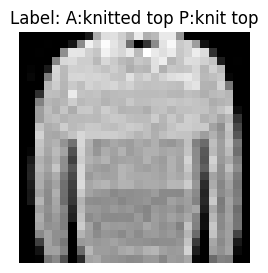

In [ ]:
ims, inp, tgt = next(iter(vision_dl['valid']))

idx = 20
actual_caption = tokenizer.decode(inp[idx]).split('\n')[0]  # as \n is padded to the label
pred_caption = generate_caption(model, ims[idx])

show_images(ims[idx], f"A:{actual_caption} P:{pred_caption}")

In [ ]:
actual_caption, pred_caption, find_lbl(actual_caption), find_lbl(pred_caption)

('knitted top', 'knit top', [2], [2])

In [ ]:


@torch.no_grad()
def generate_text(model, prompt, max_new_tokens=100, temperature=1.0):
    """
    prompt: string to start generation
    max_new_tokens: how many tokens to generate
    temperature: higher = more random, lower = more deterministic
    """
    model.eval()
    tokens = tokenizer.encode(prompt)
    tokens = torch.tensor(tokens).unsqueeze(0)  # Add batch dim
    tokens = tokens.to(multiConfig.device)

    for _ in range(max_new_tokens):
        # Crop to last seq_len tokens if needed
        context = tokens if tokens.size(1) <= gptConfig.seq_len else tokens[:, -gptConfig.seq_len:]

        # Get predictions
        with torch.autocast(device_type=multiConfig.device, dtype=torch.bfloat16):
            logits = model(context)
        logits = logits[:, -1, :] / temperature  # Focus on last token

        # Sample next token
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # Append to sequence
        tokens = torch.cat([tokens, next_token], dim=1)

    return tokenizer.decode(tokens.squeeze().tolist())

In [ ]:
print(generate_text(model, "To be or not to be", max_new_tokens=512))

To be or not to be done but love had ends,
Thou art a dain arms in service to him.
Which, could that he was some mad farth.

POLIXENES:
A word, ''t, all be root.

MENENIUS:
Goubly Grumio son:
'Thou depart of such feable, my whose fouls fault,
And since most deceit for brother
To be bold the usurp's foe that hate to thee,
Say now to very rough to Juliet digniors, and the fair;
And if not hold, who cannot death there.
More wheful ssues? What laid have the world's up,
When it disposition; I would awhile if
They we call'd your f


In [ ]:
del model

## Better Init

For GPT-style models, the most common initialization approach is:

**1. Linear layers & Embeddings:**
- Use normal distribution with mean=0, std=0.02 (GPT-2 standard)

**2. Special scaling for residual connections:**
- Scale down weights in layers that feed into residuals by 1/√(2*num_layers)
- num_layers = 4(gptConfig.n_layers)
- This prevents activations from growing too large as you stack layers

**3. Bias terms:**
- Initialize to 0
- no weight decay

**4. Layer norms:**
- Weight=1, bias=0 (usually PyTorch's default)
- no weight deacy


In [ ]:
def _init_weight(self):
  for name, module in self.named_modules():
      if isinstance(module, nn.Linear):
          module.weight.data.normal_(mean=0, std=0.02)
          module.bias.data.zero_()

          if 'linear' in name and 'linear1' not in name: # the residual wight is init for
              module.weight.data *= 1./((2*gptConfig.n_layers) ** 0.5)
      elif isinstance(module, nn.Embedding):
          module.weight.data.normal_(mean=0, std=0.02)

MultiModal._init_weight = _init_weight

In [ ]:
def decay_params(self):
  no_decay_params, decay_params = [], []
  for name, param in self.named_parameters():
      if 'bias' in name or 'layer_norm' in name:
          no_decay_params.append(param)
      else:
          decay_params.append(param)

  return decay_params, no_decay_params

MultiModal.decay_params = decay_params

In [ ]:

from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

def multi_modal_train(model, epochs):
    model = model.to(multiConfig.device)

    print(f"before training : ")
    total_loss(model)

    decay_params, no_decay_params = model.decay_params()

    optimizer = AdamW([
        {'params': decay_params, 'weight_decay': 0.1},
        {'params': no_decay_params, 'weight_decay': 0.0}
    ], lr=multiConfig.lr)

    print("---"*20)
    it = 0
    for epoch in range(epochs):
        model.train()
        train_loss, no_train = 0, 0
        train_iters.reset()

        for text_input, text_target, ims in train_iters: # Iterate directly over
            it += 1
            no_train += 1
            # Handle None for images
            if ims is not None:
                ims = ims.to(multiConfig.device)

            text_input, text_target = text_input.to(multiConfig.device), text_target.to(multiConfig.device)

            optimizer.zero_grad()

            with torch.autocast(device_type=multiConfig.device, dtype=multiConfig.dtype):
              logits = pred(model, text_input, ims) #model(text_input, ims)

              loss = cal_loss(logits, text_target)    #loss_func(logits.reshape(-1, gptConfig.vocab_size), text_target.reshape(-1))

            loss.backward()

            clip_grad_norm_(model.parameters(), gptConfig.max_grad_norm) # to clip gradients

            optimizer.step()

            train_loss += loss.item()

        valid_iters.reset()
        model.eval()
        val_loss, no_valid = 0, 0
        with torch.no_grad(), torch.autocast(device_type=gptConfig.device, dtype=gptConfig.dtype):
            for text_input, text_target, ims in valid_iters:
                no_valid += 1

                if ims is not None: ims = ims.to(multiConfig.device)

                text_input, text_target = text_input.to(multiConfig.device), text_target.to(multiConfig.device)

                logits = pred(model, text_input, ims)

                loss = cal_loss(logits, text_target)

                val_loss += loss.item()

        print(f"{epoch} -> {train_loss/no_train:.4f} : {val_loss/no_valid:.4f}")
    print("---"*20)

    print(f"after training : ")
    total_loss(model)


In [ ]:
model = MultiModal()
model._init_weight()
multi_modal_train(model, 30)

before training : 
Text Loss: 4.1801 | Vision Loss: 4.2309
------------------------------------------------------------
0 -> 1.7369 : 1.0681
1 -> 1.1509 : 0.9375
2 -> 1.0484 : 0.8886
3 -> 0.9836 : 0.8652
4 -> 0.9419 : 0.8346
5 -> 0.9125 : 0.8180
6 -> 0.8902 : 0.8025
7 -> 0.8737 : 0.7991
8 -> 0.8602 : 0.7858
9 -> 0.8485 : 0.7717
10 -> 0.8391 : 0.7735
11 -> 0.8311 : 0.7724
12 -> 0.8240 : 0.7590
13 -> 0.8172 : 0.7537
14 -> 0.8119 : 0.7523
15 -> 0.8073 : 0.7502
16 -> 0.8026 : 0.7466
17 -> 0.7985 : 0.7501
18 -> 0.7951 : 0.7431
19 -> 0.7915 : 0.7401
20 -> 0.7882 : 0.7548
21 -> 0.7896 : 0.7399
22 -> 0.7821 : 0.7385
23 -> 0.7801 : 0.7371
24 -> 0.7774 : 0.7365
25 -> 0.7756 : 0.7391
26 -> 0.7729 : 0.7327
27 -> 0.7714 : 0.7354
28 -> 0.7692 : 0.7326
29 -> 0.7670 : 0.7314
------------------------------------------------------------
after training : 
Text Loss: 1.3982 | Vision Loss: 0.1666


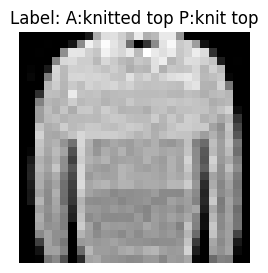

In [ ]:
pred_caption = generate_caption(model, ims[idx])
show_images(ims[idx], f"A:{actual_caption} P:{pred_caption}")

In [ ]:
actual_caption, pred_caption, find_lbl(actual_caption), find_lbl(pred_caption)

('knitted top', 'knit top', [2], [2])

In [ ]:
print(generate_text(model, "To be or not to be", max_new_tokens=512))

To be or not to be heart's weathers' own.
But possible heart neglect George,
And there was France, which shall stand thou must;
For his war, why unple forsweath flatter, and
Fair pachses truthless wanting is to England's raw;
For one to the king, carewing from of me? who
sends himself of a worthy tlaze proceeding.

COMINIUS:
You have relex-place. Goat, my lord, madam:
Stopp'd, forbear, we come of her your eyes:
Take I so good done.

CORIOLANUS:
I am not.

DUKE VINCENTIO:
Noble paid:
For the lord truerein that caredentation,

